## Loading the curated citations dataset and do processing

In [12]:
# All imports
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scripts.const import CITATION_TEMPLATES
from pyspark.sql.functions import when, isnan, col, count

import findspark
findspark.init('/Users/harshdeep/Downloads/spark-2.4.3-bin-hadoop2.7/')
from pyspark import SparkContext, SQLContext


import warnings
warnings.filterwarnings("ignore")

### Load the citations (extracted) parquet file with 21 million citations

In [13]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [14]:
all_citations = sqlContext.read.parquet('data/citations_separated.parquet/')

In [15]:
# Get citation count for all the 25 citations which can be parsed
citation_count = all_citations.groupby('type_of_citation').count().toPandas()

In [17]:
len(citation_count['type_of_citation'].unique())

35

In [40]:
# Count the number of values which are null for each column
number_of_values_with_null = all_citations.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in all_citations.columns]).toPandas()

In [84]:
null_over_sixty_percent = ((number_of_values_with_null / citation_count['count'].sum()) * 100).iloc[0] > 60
null_over_sixty_percent[null_over_sixty_percent == True]

AccessDate          True
Chapter             True
Chron               True
City                True
Degree              True
Edition             True
Encyclopedia        True
Format              True
ID_list             True
Issue               True
Pages               True
PublicationPlace    True
Series              True
TitleType           True
Volume              True
Name: 0, dtype: bool

### Get the top 300 templates (according to DLAB) and compare it with the number of citations we have got

In [19]:
top300_templates = pd.read_csv('top300_templates.csv')

In [20]:
# Only consider the templates which can be parsed by mwparserfromhell
parseable_template_count = top300_templates.loc[top300_templates['template'].isin(CITATION_TEMPLATES)]

In [21]:
merged_counts = pd.merge(
    parseable_template_count, citation_count,
    left_on='template', right_on='type_of_citation', how='inner'
).drop('template', axis=1)

merged_counts.columns = ['dlab_count', 'type_of_citation', 'curated_count']

In [24]:
merged_counts['curated_count'].sum()

23170445

In [22]:
merged_counts['bigger_than'] = merged_counts['curated_count'] - merged_counts['dlab_count']
merged_counts

,dlab_count,type_of_citation,curated_count,bigger_than
0,13340076,cite web,13971631,631555
1,4003325,cite news,4099397,96072
2,1765330,cite book,2573371,808041
3,1413205,cite journal,1747097,333892
4,304742,citation,484974,180232
5,62177,cite press release,61998,-179
6,39439,cite episode,40203,764
7,34989,cite map,35402,413
8,33637,cite encyclopedia,43864,10227
9,32269,cite report,35374,3105


In [10]:
# Load all csv files and add them into one dataframe
files = glob.glob('data/citations_ids.csv/part-*')
citation_dataframes = [pd.read_csv(f, header=None, sep=',') for f in files]
citation_with_ids = pd.concat(citation_dataframes, ignore_index=True)

In [11]:
print(citation_with_ids.shape)
total_citations = citation_with_ids.shape[0]

(3147372, 9)


In [12]:
citation_with_ids.head()

,0,1,2,3,4,5,6,7,8
0,1831197,Ray Sharkey,u'{{cite journal|last=Gliatto|first=Tom|date=J...,{ISSN=0093-7673},"[{last=Gliatto, first=Tom}]",Fatal Deceit,cite journal,NaN,Initial Section
1,1831220,Protamine sulfate,u'{{cite book|title=WHO Model Formulary 2008|d...,{ISBN=9789241547659},NaN,WHO Model Formulary 2008,cite book,World Health Organization,Initial Section
2,1831220,Protamine sulfate,u'{{cite journal | author= Kenneth Cornetta | ...,"{PMID=2786000, DOI=10.1016/0166-0934(89)90132-8}","[{last=Kenneth Cornetta}, {last=W.French Ander...",Protamine sulfate as an effective alternative ...,cite journal,NaN,Initial Section
3,1831220,Protamine sulfate,u'{{cite journal|last=Sorgi|first=FL|author2=B...,"{PMID=9349433, DOI=10.1038/sj.gt.3300484}","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",Protamine sulfate enhances lipid-mediated gene...,cite journal,NaN,Initial Section
4,1831220,Protamine sulfate,u'{{cite journal|last=Walker|first=WS|author2=...,"{PMID=6743419, PMC=481594, DOI=10.1136/hrt.52....","[{last=Walker, first=WS}, {last=Reid, KG}, {la...",Successful cardiopulmonary bypass in diabetics...,cite journal,NaN,Initial Section


In [14]:
citation_with_ids.columns = [
    'id', 'page_title', 'citation', 'id_list', 'authors',
    'citation_title', 'citation_type', 'publisher_name', 'sections'
]

In [15]:
# Percentage of values present for title of page, title of citation and authors
(citation_with_ids.count() * 100) / total_citations

id                100.000000
page_title         99.999936
citation          100.000000
id_list           100.000000
authors            92.977157
citation_title     99.881234
citation_type     100.000000
publisher_name     59.421066
sections           99.999936
dtype: float64

In [16]:
citation_with_ids.groupby('citation_type').size()

citation_type
citation                145170
cite arxiv                1626
cite av media              878
cite av media notes        125
cite book              1698507
cite conference           2475
cite dvd notes              10
cite encyclopedia        12449
cite episode                18
cite interview              33
cite journal           1212066
cite mailing list            1
cite map                  3518
cite news                51927
cite newsgroup             267
cite press release          13
cite report                694
cite serial                  7
cite sign                    2
cite speech                 12
cite techreport             49
cite thesis               2292
cite web                 15228
harvnb                       5
dtype: int64

In [17]:
# Formulate a structure for the ID_List in which we can do something meaningful
citation_with_ids['id_list'] = citation_with_ids['id_list'].apply(
    lambda x: list(item.split('=') for item in x.replace('{','').replace('}','').replace(' ', '').split(','))
)

In [18]:
# Get the kinds of ids associated with each tuple
kinds_of_ids = set()
def update_ids(x):
    for item in x:
        kinds_of_ids.add(item[0])

_ = citation_with_ids['id_list'].apply(lambda x: update_ids(x))

# Add the columns with NoneType in the previous DF
for id_ in kinds_of_ids:
    citation_with_ids[id_] = None

In [19]:
print('Total kind of Citation IDs: {}'.format(len(kinds_of_ids)))

Total kind of Citation IDs: 51


In [20]:
# Set the value of identifiers for each column, for e.g. DOI, ISBN etc.
def set_citation_val(x):
    for item in x['id_list']:
        citation_with_ids.at[x.name, item[0]] = item[1] if len(item) >= 2 else None

_ = citation_with_ids.apply(lambda x: set_citation_val(x), axis=1)

In [21]:
citation_with_ids.head()

,id,page_title,citation,id_list,authors,citation_title,citation_type,publisher_name,sections,+bronwen+w.&site,...,Vol.59,PMID,+lin,No.3(Summer,+david+w.,NewMexico,ISMN,9780896082755,ZBL,DOI
0,1831197,Ray Sharkey,u'{{cite journal|last=Gliatto|first=Tom|date=J...,"[[ISSN, 0093-7673]]","[{last=Gliatto, first=Tom}]",Fatal Deceit,cite journal,NaN,Initial Section,None,...,None,None,None,None,None,None,None,None,None,None
1,1831220,Protamine sulfate,u'{{cite book|title=WHO Model Formulary 2008|d...,"[[ISBN, 9789241547659]]",NaN,WHO Model Formulary 2008,cite book,World Health Organization,Initial Section,None,...,None,None,None,None,None,None,None,None,None,None
2,1831220,Protamine sulfate,u'{{cite journal | author= Kenneth Cornetta | ...,"[[PMID, 2786000], [DOI, 10.1016/0166-0934(89)9...","[{last=Kenneth Cornetta}, {last=W.French Ander...",Protamine sulfate as an effective alternative ...,cite journal,NaN,Initial Section,None,...,None,2786000,None,None,None,None,None,None,None,10.1016/0166-0934(89)90132-8
3,1831220,Protamine sulfate,u'{{cite journal|last=Sorgi|first=FL|author2=B...,"[[PMID, 9349433], [DOI, 10.1038/sj.gt.3300484]]","[{last=Sorgi, first=FL}, {last=Bhattacharya, S...",Protamine sulfate enhances lipid-mediated gene...,cite journal,NaN,Initial Section,None,...,None,9349433,None,None,None,None,None,None,None,10.1038/sj.gt.3300484
4,1831220,Protamine sulfate,u'{{cite journal|last=Walker|first=WS|author2=...,"[[PMID, 6743419], [PMC, 481594], [DOI, 10.1136...","[{last=Walker, first=WS}, {last=Reid, KG}, {la...",Successful cardiopulmonary bypass in diabetics...,cite journal,NaN,Initial Section,None,...,None,6743419,None,None,None,None,None,None,None,10.1136/hrt.52.1.112


In [22]:
# Save the file in the Pandas format
# citation_with_ids.to_csv('citations_with_ids.csv')

# How robust are the `Crossref` and the `Google Books API`?

In [23]:
# Importing the methods written in the script to access google books and cross ref apis
from scripts.run_apis import run_google_book_get_info, run_crossref_get_info

Let's take a few samples and query the crossref and Google books API for DOI and ISBN respectively.

In [25]:
mask_isbn_or_doi = citation_with_ids['DOI'].notnull() | citation_with_ids['ISBN'].notnull()

citation_with_isbn_or_doi = citation_with_ids[mask_isbn_or_doi][['id', 'citation_title', 'ISBN', 'DOI', 'authors']]

In [26]:
citation_with_isbn_or_doi = citation_with_isbn_or_doi.sample(n=100)

In [27]:
citation_with_isbn_or_doi.head()

,id,citation_title,ISBN,DOI,authors
1210830,40007181,Voices from the Odeyak,155021070X,None,"[{last=Posluns, first=Michael}]"
2265188,51501138,Brief Companions,0930841018,None,"[{last=Ufema, first=Joy}]"
1967556,31872124,Landlord power and rural indebtedness in colon...,978-0-7007-0470-5,None,"[{last=Cheesman, first=David}]"
2505191,33662,Functional analysis,978-0-07-054236-5,None,"[{link=Walter Rudin, last=Rudin, first=Walter}]"
2857153,5617,Cells infected with scrapie and Creutzfeldt\u2...,None,10.1073/pnas.0610999104,"[{last=Manuelidis, first=L}, {last=Yu, first=Z..."


In [28]:
citation_with_isbn_or_doi['retrieved_title'] = [[] for i in citation_with_isbn_or_doi.index]
citation_with_isbn_or_doi['retrieved_author'] = [[] for i in citation_with_isbn_or_doi.index]
citation_with_isbn_or_doi['api_type'] = ['' for i in citation_with_isbn_or_doi.index]

Crossref is great for DOI, but does not return a lot of information for ISBN. Google books is better for ISBN but it limits the amount of requests one could send so thats why we are testing it on a smaller sample case.

In [29]:
for i in range(len(citation_with_isbn_or_doi)):
    title = []
    author = []
    row = citation_with_isbn_or_doi.iloc[i] # Get the particular row
    if row['DOI']:
        result_crossref = run_crossref_get_info(doi=row['DOI'])
        citation_with_isbn_or_doi.iloc[i, 7] = 'Crossref'

        if result_crossref.status_code != 200:
            title.append('No title mentioned')
            author.append('No authors mentioned')
            continue

        crossref_message = result_crossref.json()['message']
        
        if 'title' in crossref_message:
            title.extend(crossref_message['title'])
        else:
            title.append('No title mentioned')
        
        if 'author' in crossref_message:
            author.extend([
                a.get('given', '') + ' ' + a.get('family', '')
                for a in crossref_message['author']
            ])
        else:
            author.append('No authors mentioned')

    if not row['DOI'] and row['ISBN']:
        isbn = row['ISBN'].replace('-', '')
        result_google = run_google_book_get_info(isbn=isbn).json()
        citation_with_isbn_or_doi.iloc[i, 7] = 'Google'
        
        if 'items' not in result_google:
            row['retrieved_title'] = 'No title mentioned'
            row['retrieved_author'] = 'No authors mentioned'
            continue
        
        for item in result_google['items']:
            title.append(item['volumeInfo'].get('title', 'No title mentioned'))
            author.extend(item['volumeInfo'].get('authors', ['No authors mentioned']))
    
    if i % 50 == 0:
        print('Done with {} citations'.format(i + 1))
    
    citation_with_isbn_or_doi.iloc[i]['retrieved_title'].extend(title)
    citation_with_isbn_or_doi.iloc[i]['retrieved_author'].extend(author)

Done with 51 citations


In [30]:
citation_with_isbn_or_doi

,id,citation_title,ISBN,DOI,authors,retrieved_title,retrieved_author,api_type
1210830,40007181,Voices from the Odeyak,155021070X,None,"[{last=Posluns, first=Michael}]",[],[],Google
2265188,51501138,Brief Companions,0930841018,None,"[{last=Ufema, first=Joy}]",[Brief Companions],[Joy Ufema],Google
1967556,31872124,Landlord power and rural indebtedness in colon...,978-0-7007-0470-5,None,"[{last=Cheesman, first=David}]",[Landlord Power and Rural Indebtedness in Colo...,[David Cheesman],Google
2505191,33662,Functional analysis,978-0-07-054236-5,None,"[{link=Walter Rudin, last=Rudin, first=Walter}]",[Functional Analysis],[Walter Rudin],Google
2857153,5617,Cells infected with scrapie and Creutzfeldt\u2...,None,10.1073/pnas.0610999104,"[{last=Manuelidis, first=L}, {last=Yu, first=Z...",[Cells infected with scrapie and Creutzfeldt-J...,"[L. Manuelidis, Z.-X. Yu, N. Barquero, B. Mull...",Crossref
224874,34149970,"Emotion, Identity and Death: Mortality Across ...",978-1-4094-8179-9,None,"[{last=Douglas J. Davies}, {last=Chang-Won Park}]","[Emotion, Identity and Death]","[Mr Chang-Won Park, Professor Douglas J. Davies]",Google
1055154,216353,Microeconomics and Behavior,978-0-07-126349-8,None,"[{last=Frank, first=Robert}]",[],[],Google
2066158,1473494,Filibusters and expansionists: Jeffersonian ma...,978-0-8173-0880-3,None,"[{last=Frank L. Owsley, Jr.}]",[Filibusters and Expansionists],"[Frank L. Owsley, Gene A. Smith]",Google
1751046,1404433,Episodic massive mud eruptions from submarine ...,None,10.1002/2015GL065713,"[{last=Kioka, first=Arata}, {last=Ashi, first=...",[Episodic massive mud eruptions from submarine...,"[Arata Kioka, Juichiro Ashi]",Crossref
535920,38814337,Congo. Een geschiedenis.,9789023456636,None,"[{last=Van Reybrouck, first=David}]",[],[],Google


Doing analysis of the Google and Crossref API - as to how many authors and title are equal?

In [31]:
total_google_samples = len(citation_with_isbn_or_doi[citation_with_isbn_or_doi['api_type'] == 'Google'])
total_crossref_samples = len(citation_with_isbn_or_doi[citation_with_isbn_or_doi['api_type'] == 'Crossref'])

In [32]:
print('Google Samples: {}\nCrossref Samples: {}'.format(total_google_samples, total_crossref_samples))

Google Samples: 60
Crossref Samples: 40


Lets perform some API robustness test on titles..

In [35]:
# Using Fuzzy String Matching to get an approximate matching of string instead of actual one
from fuzzywuzzy import fuzz

def get_ratio(row, col1, col2):
    actual_ = row[col1] if row[col1] else 'No title'
    retrieved_ = row[col2][0] if len(row[col2]) >= 1 else 'No retrieved title'
    return fuzz.token_set_ratio(actual_, retrieved_)

As you can see Crossref is more precise with its results and its API is more robust than Google Books since Google Books is more like a search engine for books and returns more broader results. Also, Crossref is a specialist API and hence results are more specific.

Some of the edge cases which are not addressed is sometimes the title retrieved are in another language, but these cases are far and less.

In [37]:
citation_with_isbn_or_doi['title_percent_match'] = citation_with_isbn_or_doi.apply(
    get_ratio, args=('citation_title', 'retrieved_title'), axis=1)
citation_with_isbn_or_doi[['api_type', 'title_percent_match']].groupby('api_type').mean()

,title_percent_match
api_type,
Crossref,97.475000
Google,83.616667


Lets now apply the robustness test on authors..

In [38]:
# Preprocess authors so that we disappear the 'last=' and 'first=' phrase and convert them into list
def preprocess_authors(row):
    authors = ''
    authors = (
        'No authors' if isinstance(row['authors'], float) or not row['authors']
        else row['authors'].split('}, {')
    )
    for ch in [']', '[', '{', '}', 'first=', 'last=', ',', 'link=']:
        authors = [i.replace(ch, '') for i in authors]
    return len(authors), ', '.join(authors)

In [39]:
citation_temp_authors = citation_with_isbn_or_doi[['authors', 'retrieved_author', 'api_type']]

# Get the length of the number of author and the length of the number of retrieved authors
citation_temp_authors['len_authors'], citation_temp_authors['joined_authors'] = zip(*citation_temp_authors.apply(preprocess_authors, axis=1))
citation_temp_authors['len_retrieved_author'] = citation_temp_authors['retrieved_author'].apply(lambda x: len(x))
citation_temp_authors['retrieved_author'] = citation_temp_authors['retrieved_author'].apply(lambda x: ', '.join(x))

86 times the number of authors were equal or more when retrieved which means both the APIs were quite robust when in comes to term of retreiving the number of authors for a publication.

In [40]:
(citation_temp_authors['len_authors'] <= citation_temp_authors['len_retrieved_author']).value_counts()

True     80
False    20
dtype: int64

As you can see the percentages are low but this is partially because of the different annotations in the way which the authors were written in, but again we see that Crossref API is more specific and precise than Google Books.

In [41]:
citation_temp_authors['author_percent_match'] = citation_temp_authors.apply(
    get_ratio, args=('joined_authors', 'retrieved_author'), axis=1)
citation_temp_authors[['api_type', 'author_percent_match']].groupby('api_type').mean()

,author_percent_match
api_type,
Crossref,53.45
Google,22.80


### How do the identifiers appear with each other?

* Do we have citations with a lot of two identifiers?

In [42]:
identifiers_existing = citation_with_ids[['DOI', 'ISBN', 'ISSN', 'PMC', 'PMID']].notnull()

In [43]:
identifiers_existing.head()

,DOI,ISBN,ISSN,PMC,PMID
0,False,False,True,False,False
1,False,True,False,False,False
2,True,False,False,False,True
3,True,False,False,False,True
4,True,False,False,True,True


In [44]:
all_columns = identifiers_existing.columns
frequency_citation = dict()

def get_frequency_of_identifiers_appearing(x):
    available_citation_types = tuple([column for column in all_columns if x[column]])
    frequency_citation.setdefault(available_citation_types, 0)
    frequency_citation[available_citation_types] += 1

_ = identifiers_existing.apply(lambda x: get_frequency_of_identifiers_appearing(x), axis=1)

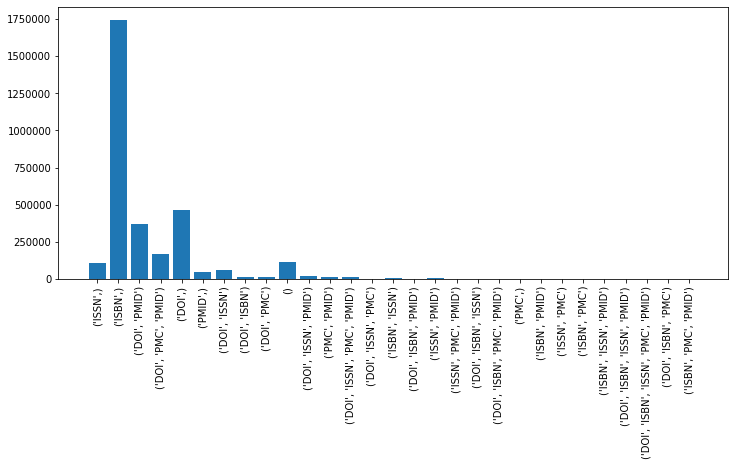

In [45]:
# Make a graph of the frequency distribution calculated above
names = list(frequency_citation.keys())
values = list(frequency_citation.values())

plt.rcParams["figure.figsize"] = (12,5)
plt.xticks(rotation=90)
plt.bar(range(len(frequency_citation)),values,tick_label=names)
plt.show()

## Loading the wikipedia dataset with identifiers

In [4]:
CITATION_WITH_IDENTIFIERS = '../Citations_with_Identifiers/enwiki.tsv.tar.gz'

wiki_en_identifiers = pd.read_csv(CITATION_WITH_IDENTIFIERS, compression='gzip', sep='\t')

In [5]:
wiki_en_identifiers.head(5)

,enwiki.tsv,page_title,rev_id,timestamp,type,id
0,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20078357
1,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0604502
2,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,astro-ph/0003329
3,2867096.0,Mu Aquilae,508363722.0,2012-08-20T22:56:21Z,arxiv,0708.1752
4,2867096.0,Mu Aquilae,503137751.0,2012-07-19T16:08:41Z,doi,10.1051/0004-6361:20064946


In [6]:
print('Total citation identifiers for English Wikipedia: {}'.format(wiki_en_identifiers.shape[0]))

Total citation identifiers for English Wikipedia: 3794696


In [7]:
wiki_en_identifiers['type'].unique() # Labels which have unique IDSs

array(['doi', 'arxiv', 'isbn', 'pmid', 'pmc', nan], dtype=object)

In [8]:
# Remove the one with the NaN value
wiki_en_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'].notnull()]

In [9]:
# Adding a boolean to check if the citation is in other dataset - to 
wiki_en_identifiers['is_in_other_dataset'] = False

In [11]:
wiki_en_identifiers['page_title'].nunique()

857764

In [37]:
wiki_en_identifiers['id'].nunique()

2190762

## Revision Analysis

In [52]:
# curated_title_id = citation_with_ids[['page_', 'r_id', 'r_parentid']]
# curated_title_id.head()

As we can see that many parent ids in our dataset are not present in the citation with identifiers dataset which should be kept in mind for further analysis and can be classified as a reason that we might get less citations.

In [53]:
# r_parentid_which_are_present = curated_title_id['r_parentid'].isin(wiki_en_identifiers['rev_id'])
# total_number_of_r_parentid_in_wiki = np.sum(r_parentid_which_are_present)
# print(curated_title_id.shape[0], wiki_en_identifiers['rev_id'].shape[0], total_number_of_r_parentid_in_wiki)

## Comparing the two datasets

The gap exists between the two datasets (3.74 mil, 3.14 mil) of about 600,000  because we are looking only at certain citation formats which can be parsed by the `mwparserfromhell`. But still we have got 90% of the citation data by looking at just mere numbers. The 10% deficit is because of the dataset used by wiki identifiers is for revision where we are using a dataset relating to a particular date.

In [54]:
gap = wiki_en_identifiers.shape[0] - total_citations

print('The total gap between between total number of wikipedias citations and our citations: {}'.format(gap))

The total gap between between total number of wikipedias citations and our citations: 647323


In [55]:
def get_citations_specific_to_type(wiki_type, curated_type):
    type_wiki_identifiers = wiki_en_identifiers[wiki_en_identifiers['type'] == wiki_type]
    type_citations_curated = citation_with_ids[citation_with_ids[curated_type].notnull()]
    
    # Just considering the unique ones since they are a lot of duplicated DOIs
    # Maybe one citation is cited in many different pages
    number_of_identifiers_wiki = type_wiki_identifiers['id'].shape[0]
    number_of_identifiers_curated = type_citations_curated['DOI'].shape[0]
    print('The total number of unique {} wiki identifiers: {}'.format(wiki_type, number_of_identifiers_wiki))
    print('The total number of unique {} curated identifiers: {}'.format(curated_type, number_of_identifiers_curated))
    
    print('\nThe difference between wiki and curated is: {}'.format(
        number_of_identifiers_wiki - number_of_identifiers_curated)
    )
    
    return type_wiki_identifiers, type_citations_curated

### How many DOI identifiers are common?

In [56]:
doi_wiki_identifiers, doi_citations_curated = get_citations_specific_to_type('doi', 'DOI')

The total number of unique doi wiki identifiers: 1211807
The total number of unique DOI curated identifiers: 1112084

The difference between wiki and curated is: 99723


In [57]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia
doi_which_are_present = doi_wiki_identifiers['id'].isin(doi_citations_curated['DOI'])
total_number_of_doi_identifiers_in_wiki = np.sum(doi_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[doi_which_are_present.index] = doi_which_are_present.values

In [58]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        doi_citations_curated.shape[0],
        doi_wiki_identifiers.shape[0],
        total_number_of_doi_identifiers_in_wiki,
        doi_citations_curated.shape[0] - total_number_of_doi_identifiers_in_wiki,
        doi_which_are_present[~doi_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 1112084 
Total Wiki:1211807 
Curated which are in Wiki: 1051578 
Gap: 60506 -> Wiki which are not identified: 160229


### How many ISBN (also ISSN) identifiers are common?

* ISBNs are International Standard Book Numbers. They can be assigned to monographic publications, such as books, e-books and audiobooks.
* ISMNs are International Standard Music Numbers. They can be assigned to notated music (scores and sheet music) whether published in print, online or in other media.
* ISSNs are International Standard Serial Numbers. They can be assigned to periodical publications, such as magazines and journals.

In [59]:
isbn_wiki_identifiers, isbn_citations_curated = get_citations_specific_to_type('isbn', 'ISBN')

The total number of unique isbn wiki identifiers: 1740812
The total number of unique ISBN curated identifiers: 1763305

The difference between wiki and curated is: -22493


### Trying to normalize all the ISBN (also need to do for ISSN)

* So if '00-11-223344' it becomes '0011223344'

In [60]:
# Check if the wikipedia citation identifiers does not have hyphens
np.sum(isbn_wiki_identifiers['id'].apply(lambda x: '-' in x))

0

In [61]:
isbn_citations_curated['ISBN'] = isbn_citations_curated['ISBN'].apply(lambda x: x.replace('-', ''))

In [62]:
# Check if curated DOIs are contained in the already obtained dataset from Wikipedia

isbn_which_are_present = isbn_wiki_identifiers['id'].isin(isbn_citations_curated['ISBN'])
total_number_of_isbn_identifiers_in_wiki = np.sum(isbn_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[isbn_which_are_present.index] = isbn_which_are_present.values

In [63]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        isbn_citations_curated.shape[0],
        isbn_wiki_identifiers.shape[0],
        total_number_of_isbn_identifiers_in_wiki,
        isbn_citations_curated.shape[0] - total_number_of_isbn_identifiers_in_wiki,
        isbn_which_are_present[~isbn_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 1763305 
Total Wiki:1740812 
Curated which are in Wiki: 1637545 
Gap: 125760 -> Wiki which are not identified: 103267


### Now time for ISSN...

In [64]:
# But the stats for this does not matter!!!
# because the hypothesis is that ISSN is contained inside ISBN - but only some of them do!
isbn_wiki_identifiers, issn_citations_curated = get_citations_specific_to_type('isbn', 'ISSN')

The total number of unique isbn wiki identifiers: 1740812
The total number of unique ISSN curated identifiers: 207315

The difference between wiki and curated is: 1533497


In [65]:
# Normalizing it again like ISBN
issn_citations_curated['ISSN'] = issn_citations_curated['ISSN'].apply(lambda x: x.replace('-', ''))

In [66]:
issn_which_are_present = issn_citations_curated['ISSN'].isin(isbn_wiki_identifiers['id'])
total_number_of_issn_identifiers_in_wiki = np.sum(issn_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[issn_which_are_present.index] = issn_which_are_present.values

In [67]:
print(
    'Stats:\nTotal Curated: {} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        issn_citations_curated.shape[0],
        total_number_of_issn_identifiers_in_wiki,
        issn_citations_curated.shape[0] - total_number_of_issn_identifiers_in_wiki,
        issn_which_are_present[~issn_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 207315 
Curated which are in Wiki: 8053 
Gap: 199262 -> Wiki which are not identified: 199262


What we can see is that ISSN exists in our `curated` dataset and only some of them of these are contained in the existing `wikipedia dataset`. Most of them do not exist and hence the hypothesis is potentially not correct. Also, some of these can be counter examples since they are magazines and music volumes which are not scientific in nature.

### How many PMID identifiers are common?

In [68]:
pmid_wiki_identifiers, pmid_citations_curated = get_citations_specific_to_type('pmid', 'PMID')

The total number of unique pmid wiki identifiers: 609848
The total number of unique PMID curated identifiers: 629434

The difference between wiki and curated is: -19586


In [69]:
# Check if curated PMIDs are contained in the already obtained dataset from Wikipedia
pmid_which_are_present = pmid_citations_curated['PMID'].isin(pmid_wiki_identifiers['id'])
total_number_of_pmid_identifiers_in_wiki = np.sum(pmid_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[pmid_which_are_present.index] = pmid_which_are_present.values

In [70]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        pmid_citations_curated.shape[0],
        pmid_wiki_identifiers.shape[0],
        total_number_of_pmid_identifiers_in_wiki,
        pmid_citations_curated.shape[0] - total_number_of_pmid_identifiers_in_wiki,
        pmid_which_are_present[~pmid_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 629434 
Total Wiki:609848 
Curated which are in Wiki: 594216 
Gap: 35218 -> Wiki which are not identified: 35218


### How many PMC identifiers are common?

In [71]:
pmc_wiki_identifiers, pmc_citations_curated = get_citations_specific_to_type('pmc', 'PMC')

The total number of unique pmc wiki identifiers: 181240
The total number of unique PMC curated identifiers: 203502

The difference between wiki and curated is: -22262


In [72]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
pmc_which_are_present = pmc_citations_curated['PMC'].isin(pmc_wiki_identifiers['id'])
total_number_of_pmc_identifiers_in_wiki = np.sum(pmc_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[pmc_which_are_present.index] = pmc_which_are_present.values

In [73]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        pmc_citations_curated.shape[0],
        pmc_wiki_identifiers.shape[0],
        total_number_of_pmc_identifiers_in_wiki,
        pmc_citations_curated.shape[0] - total_number_of_pmc_identifiers_in_wiki,
        pmc_which_are_present[~pmc_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 203502 
Total Wiki:181240 
Curated which are in Wiki: 179173 
Gap: 24329 -> Wiki which are not identified: 24329


### How many ArXiV identifiers are common?

In [74]:
arxiv_wiki_identifiers, arxiv_citations_curated = get_citations_specific_to_type('arxiv', 'ARXIV')

The total number of unique arxiv wiki identifiers: 50988
The total number of unique ARXIV curated identifiers: 36490

The difference between wiki and curated is: 14498


In [75]:
# Check if curated PMCs are contained in the already obtained dataset from Wikipedia
arxiv_which_are_present = arxiv_citations_curated['ARXIV'].isin(arxiv_wiki_identifiers['id'])
total_number_of_arxiv_identifiers_in_wiki = np.sum(arxiv_which_are_present)
wiki_en_identifiers['is_in_other_dataset'].loc[arxiv_which_are_present.index] = arxiv_which_are_present.values

In [76]:
print(
    'Stats:\nTotal Curated: {} \nTotal Wiki:{} \nCurated which are in Wiki: {} \nGap: {} -> Wiki which are not identified: {}'.format(
        arxiv_citations_curated.shape[0],
        arxiv_wiki_identifiers.shape[0],
        total_number_of_arxiv_identifiers_in_wiki,
        arxiv_citations_curated.shape[0] - total_number_of_arxiv_identifiers_in_wiki,
        arxiv_which_are_present[~arxiv_which_are_present].shape[0]
    )
)

Stats:
Total Curated: 36490 
Total Wiki:50988 
Curated which are in Wiki: 30008 
Gap: 6482 -> Wiki which are not identified: 6482
